In [1]:
import matplotlib.pyplot as plt
import deepdish as dd
from brian2.only import *
import numpy_ as np
import model
from spike_utils import iterspikes
from conf.params import params
from util import ensure_unit

In [2]:
simulate = True
filename = 'data/memory_duration_2.h5'

First, find the E-E indegree distribution:

Minimum: 13
Median: 40.0
Maximum: 72


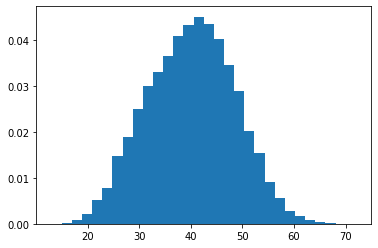

In [3]:
import conf.isi5_500 as cfg
indegrees = []
for net in range(cfg.N_networks):
    try:
        res = dd.io.load(cfg.netfile.format(net=net))
    except:
        pass
    EE = res['W'][:cfg.params['N_exc'], :cfg.params['N_exc']]
    indegrees.append((EE>0).sum(0))

indegrees = np.asarray(indegrees).flatten()
plt.hist(indegrees, bins=30, density=True)
print('Minimum:', np.min(indegrees))
print('Median:', np.median(indegrees))
print('Maximum:', np.max(indegrees))
max_indegree = np.max(indegrees)

Next, probe the memory of threshold adaptation:

In [4]:
defaultclock.dt = params['dt']

In [5]:
def get_singular_input(N_inputs, period):
    return SpikeGeneratorGroup(N_inputs, np.arange(N_inputs), np.zeros(N_inputs)*ms, sorted=True, period=period, name='Input')

In [6]:
def get_probe(params, Input, record):
    params = params.copy()
    params['N_exc'] = 1

    Net = Network()
    Exc = model.create_excitatory(Net, X=[0*mm], Y=[0*mm], params=params, clock=defaultclock, extras=record, enforced_spikes=False, suffix='')
    Syn = model.make_exc_synapse(Input, Exc, np.arange(Input.N), np.zeros(Input.N, int), params['w_exc_mean'], params, name='Syn')

    XM = SpikeMonitor(Exc, record=[0], name='XM')
    if len(record):
        SM = StateMonitor(Exc, variables=record, record=[0], name='SM')
        Net.add(SM)

    Net.add(Input, Syn, XM)
    return Net

In [7]:
def get_recovery_time(params, N_inputs, N_pulses, input_creation_fn, isi=1*second, min_isi=10*msecond, record=(), exact=False):
    isi = int(isi/params['dt'])
    recovery_time = np.zeros(len(N_inputs))*second
    outputs = []
    for i, inputs in enumerate(N_inputs):
        lower_bound, upper_bound = int(min_isi/params['dt']), None
        initial = True
        while True:
            Input = input_creation_fn(inputs, isi*params['dt'])
            Net = get_probe(params, Input, record)
            Net.run((N_pulses+1)*isi*params['dt'])
            if Net['XM'].t[:].size == 0:
                upper_bound = 0
                break

            recovered = True
            for j, (_, x) in enumerate(iterspikes(Net['XM'].t, Net['XM'].t, (N_pulses+1), isi*params['dt'], dt=params['dt'])):
                if exact:
                    x = ((x + params['dt']/2) / params['dt']).astype(int)
                    if j == 0:
                        n0 = x
                    elif len(n0) != len(x) or np.unique(x-n0).size > 1:
                        recovered = False
                        break
                else:
                    if j == 0:
                        n0 = len(x)
                    elif len(x) != n0:
                        recovered = False
                        break

            if recovered:
                upper_bound = isi
                initial = False
            else:
                lower_bound = isi
            if initial:
                upper_bound = 2*isi
            elif upper_bound - lower_bound < 2:
                break
            isi = int((lower_bound+upper_bound)/2)
        recovery_time[i] = upper_bound*params['dt']
        if isi != upper_bound and upper_bound > 0:
            Input = input_creation_fn(inputs, upper_bound*params['dt'])
            Net = get_probe(params, Input, record)
            Net.run((N_pulses+1)*upper_bound*params['dt'])
        outputs.append({
            'V': Net['SM'].v.T,
            'g': Net['SM'].g_exc.T,
            'th': (Net['SM'].th_adapt.T if hasattr(Net['SM'], 'th_adapt') else 0*mV) + params['v_threshold'],
            'spiketimes': Net['XM'].t[:]
        })
    return recovery_time, outputs

In [8]:
def plot_explanatory_figure(params, isi, p1, V, g, th, spiketimes, tmax=None):
    isi = int((isi + params['dt']/2) / params['dt'])
    tmax = isi if tmax is None else int((tmax + params['dt']/2) / params['dt'])
    t = np.arange(isi)*params['dt'] / msecond
    fig, axs = plt.subplots(2, figsize=(6,6), constrained_layout=True)
    axs[0].plot(V[:tmax]/mV, c='C0', ls='--', alpha=.5)
    if p1 > 1:
        axs[0].plot(V[(p1-1)*isi : (p1-1)*isi + tmax]/mV, c='C0', alpha=.7)
    axs[0].plot(V[p1*isi : p1*isi + tmax]/mV, c='C0', label='Membrane voltage')
    try:
        for _ in th:
            break
        axs[0].plot(th[:tmax]/mV, c='C2', ls='--', alpha=.5)
        if p1 > 1:
            axs[0].plot(th[(p1-1)*isi : (p1-1)*isi + tmax]/mV, c='C2', alpha=.7)
        axs[0].plot(th[p1*isi : p1*isi + tmax]/mV, c='C2', label='Firing threshold')
    except TypeError:
        axs[0].axhline(th/mV, c='C2', label='Firing threshold')
    axs[0].set_ylabel('Voltage (mV)')
    axs[0].set_xlabel('Time (ms)')
    axs[0].legend()

    axs[1].plot(g[:tmax], c='C1', ls='--', alpha=.5)
    if p1 > 1:
        axs[1].plot(g[(p1-1)*isi : (p1-1)*isi + tmax], c='C1', alpha=.7)
    axs[1].plot(g[p1*isi : p1*isi + tmax], c='C1')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Synaptic conductance')

Attempt 1: Plot recovery of a single, synchronous burst of up to max(indegree) presynaptic excitatory pulses. That is: Fire such a pulse, and find out how long it takes before the next pulse evokes the same number of spikes in the postsynaptic probe.

In [9]:
recovery_TA, out = get_recovery_time(
    {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 1, get_singular_input,
    isi=params['th_tau'], record=('v', 'th_adapt', 'g_exc'))

WARNING    'dt' is an internal variable of group 'Exc', but also exists in the group-specific namespace with the value 1. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


11. * msecond

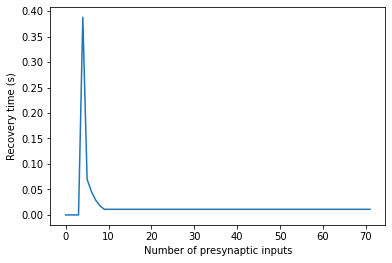

In [10]:
plt.plot(recovery_TA)
plt.ylabel('Recovery time (s)')
plt.xlabel('Number of presynaptic inputs')
recovery_TA[-1]

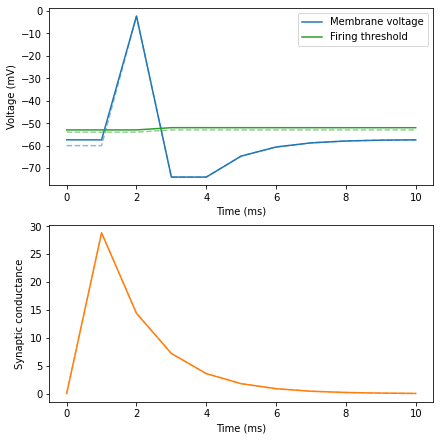

In [11]:
plot_explanatory_figure(params, recovery_TA[-1], 1, **out[-1])

This isn't working so well: The input for multiple neurons completely overwhelms adaptation.

Attempt 2: Repeat the input pulse a few times, aiming towards a steady state.

In [12]:
if simulate:
    recovery_TA, recovery_TA_data = get_recovery_time(
        {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 10, get_singular_input,
        isi=params['th_tau'], record=('v', 'th_adapt', 'g_exc'))
else:
    recovery_TA = ensure_unit(dd.io.load(filename, '/recovery_TA'), second)
    recovery_TA_data = ensure_unit(dd.io.load(filename, '/recovery_TA_data'), {'V':volt, 'spiketimes':second, 'th':volt})

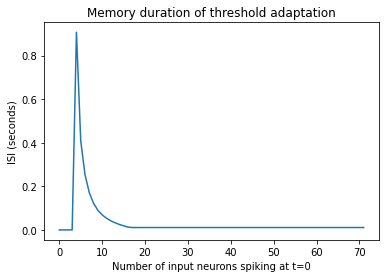

In [13]:
plt.plot(recovery_TA)
plt.xlabel('Number of input neurons spiking at t=0')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of threshold adaptation');

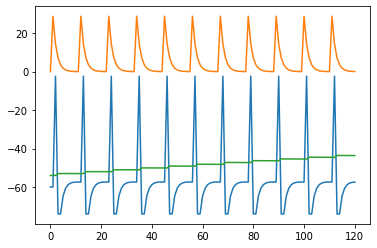

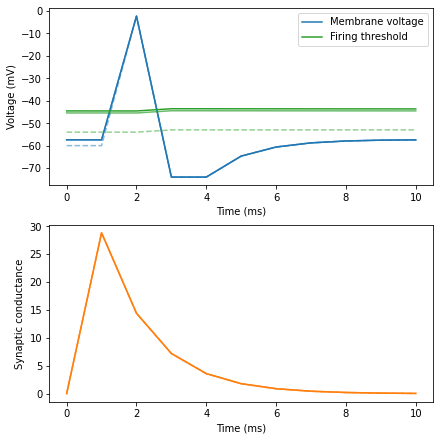

In [14]:
plt.plot(recovery_TA_data[-1]['V']/mV)
plt.plot(recovery_TA_data[-1]['g'])
plt.plot(recovery_TA_data[-1]['th']/mV);
plot_explanatory_figure(params, recovery_TA[-1], 10, **recovery_TA_data[-1])

I don't think we're anywhere near steady state here, and the result is stil disappointing. Before addressing this, let's have a look at STD.

In [15]:
if simulate:
    recovery_STD, recovery_STD_data = get_recovery_time(
        {**params, 'th_ampl': 0*mV}, np.arange(max_indegree)+1, 10, get_singular_input,
        isi=params['tau_rec'], record=('v', 'g_exc'))
else:
    recovery_STD = ensure_unit(dd.io.load(filename, '/recovery_STD'), second)
    recovery_STD_data = ensure_unit(dd.io.load(filename, '/recovery_STD_data'), {'V':volt, 'spiketimes':second, 'th':volt})

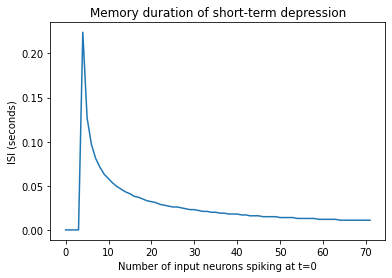

In [16]:
plt.plot(recovery_STD)
plt.xlabel('Number of input neurons spiking at t=0')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of short-term depression');

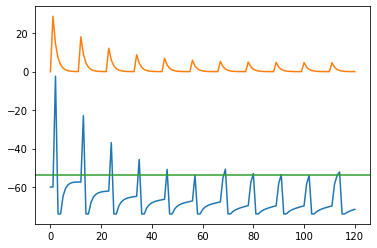

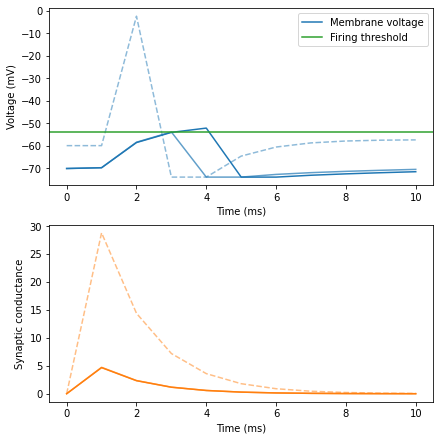

In [17]:
plt.plot(recovery_STD_data[-1]['V']/mV)
plt.plot(recovery_STD_data[-1]['g'])
plt.axhline(recovery_STD_data[-1]['th']/mV, c='C2');
plot_explanatory_figure(params, recovery_STD[-1], 10, **recovery_STD_data[-1])

STD of course reaches steady state sooner, the above looks reasonable.

Attempt 3: Let's get a little more realistic. Spread the inputs over 30 ms first, and vary spike rate alongside input size in a second step:

In [18]:
scattered_spikes = {}

def get_scattered_input(N_inputs, period, N_ticks, pspike, dt, rng=None):
    if N_inputs not in scattered_spikes:
        scattered_spikes[N_inputs] = get_scattered_spikes(N_ticks, N_inputs, pspike, dt, rng)
    return SpikeGeneratorGroup(N_inputs, *scattered_spikes[N_inputs], period=period, name='Input')

def get_scattered_spikes(N_ticks, N_inputs, pspike, dt, rng=None):
    rng = rng or np.random.default_rng()
    while True:
        i = rng.choice(N_inputs, int(N_inputs*pspike))
        t = rng.choice(N_ticks, int(N_inputs*pspike))
        q = np.zeros((N_inputs, N_ticks))
        np.add.at(q, (i, t), 1)
        if not np.any(q>1):
            return i, t*dt

from functools import partial

In [19]:
if simulate:
    scattered_recovery_TA, scattered_recovery_TA_data = get_recovery_time(
        {**params, 'tau_rec': 0*ms}, np.arange(max_indegree)+1, 10, partial(get_scattered_input, N_ticks=30, pspike=1, dt=params['dt']),
        isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'))
else:
    scattered_recovery_TA = ensure_unit(dd.io.load(filename, '/scattered_recovery_TA'), second)
    scattered_recovery_TA_data = ensure_unit(dd.io.load(filename, '/scattered_recovery_TA_data'), {'V':volt, 'spiketimes':second, 'th':volt})

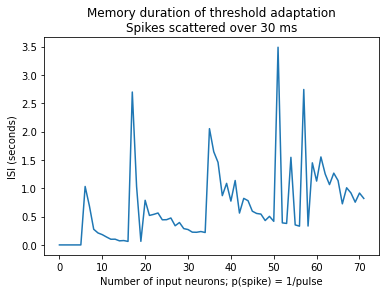

In [20]:
plt.plot(scattered_recovery_TA)
plt.xlabel('Number of input neurons; p(spike) = 1/pulse')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms');

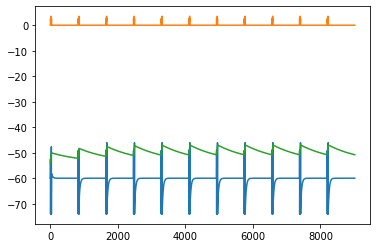

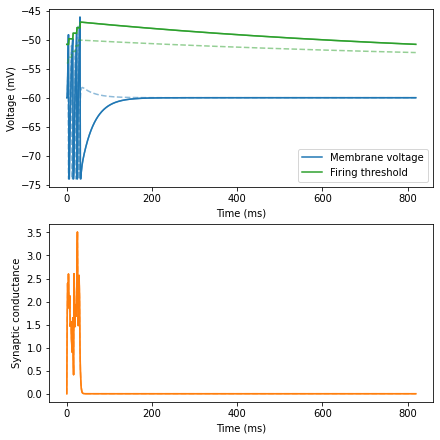

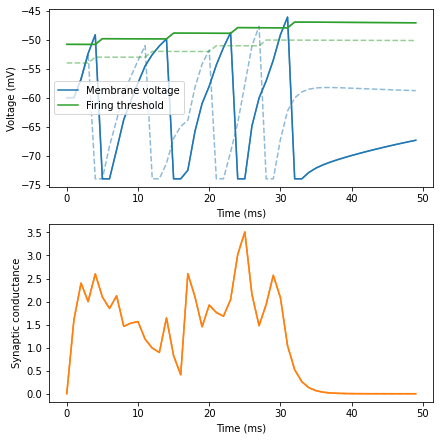

In [21]:
plt.plot(scattered_recovery_TA_data[-1]['V']/mV)
plt.plot(scattered_recovery_TA_data[-1]['g'])
plt.plot(scattered_recovery_TA_data[-1]['th']/mV);
plot_explanatory_figure(params, scattered_recovery_TA[-1], 10, **scattered_recovery_TA_data[-1])
plot_explanatory_figure(params, scattered_recovery_TA[-1], 10, **scattered_recovery_TA_data[-1], tmax=50*ms)

In [22]:
if simulate:
    scattered_recovery_STD, scattered_recovery_STD_data = get_recovery_time(
        {**params, 'th_ampl': 0*mV}, np.arange(max_indegree)+1, 10, partial(get_scattered_input, N_ticks=30, pspike=1, dt=params['dt']),
        isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'))
else:
    scattered_recovery_STD = ensure_unit(dd.io.load(filename, '/scattered_recovery_STD'), second)
    scattered_recovery_STD_data = ensure_unit(dd.io.load(filename, '/scattered_recovery_STD_data'), {'V':volt, 'spiketimes':second, 'th':volt})

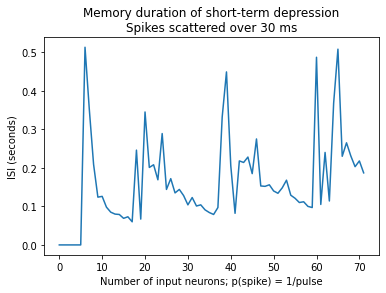

In [23]:
plt.plot(scattered_recovery_STD)
plt.xlabel('Number of input neurons; p(spike) = 1/pulse')
plt.ylabel('ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

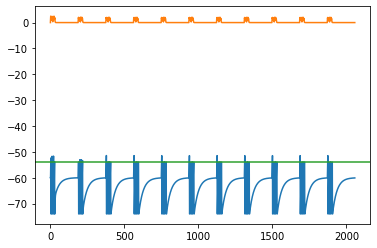

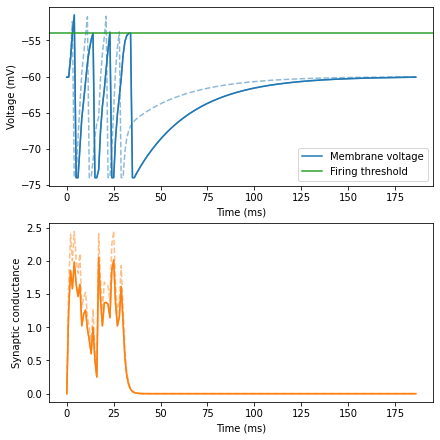

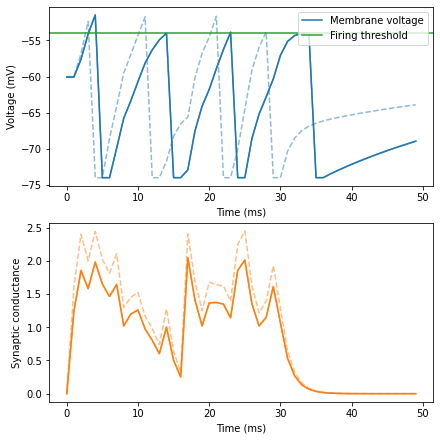

In [24]:
plt.plot(scattered_recovery_STD_data[-1]['V']/mV)
plt.plot(scattered_recovery_STD_data[-1]['g'])
plt.axhline(scattered_recovery_STD_data[-1]['th']/mV, c='C2');
plot_explanatory_figure(params, scattered_recovery_STD[-1], 10, **scattered_recovery_STD_data[-1])
plot_explanatory_figure(params, scattered_recovery_STD[-1], 10, **scattered_recovery_STD_data[-1], tmax=50*ms)

This looks reasonable. Let's try it across a number of spike probabilities/rates:

In [25]:
def get_recovery_time_2D(params, N_inputs, N_pulses, pspike, input_creation_fn, **kwargs):
    recovery_time = []
    recovery_data = []
    for p in pspike:
        print(p)
        scattered_spikes.clear()
        rec, rec_data = get_recovery_time(params, N_inputs, N_pulses, partial(input_creation_fn, pspike=p), **kwargs)
        recovery_time.append(rec/second)
        recovery_data.append(rec_data)
    return np.asarray(recovery_time)*second, recovery_data

In [26]:
pspike = np.arange(0.2, 2.1, 0.2)
N_inputs = np.arange(max_indegree)+1

In [27]:
if simulate:
    pscattered_recovery_TA, pscattered_recovery_TA_data = get_recovery_time_2D(
        {**params, 'tau_rec': 0*ms}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
        isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'))
else:
    pscattered_recovery_TA = ensure_unit(dd.io.load(filename, '/pscattered_recovery_TA'), second)
    pscattered_recovery_TA_data = ensure_unit(dd.io.load(filename, '/pscattered_recovery_TA_data'), {'V':volt, 'spiketimes':second, 'th':volt})

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


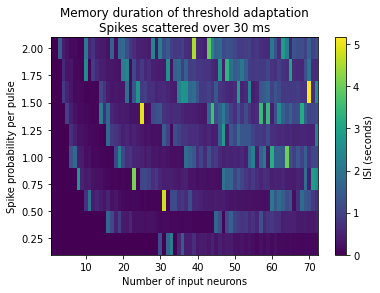

In [28]:
plt.pcolormesh(N_inputs, pspike, pscattered_recovery_TA/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms');

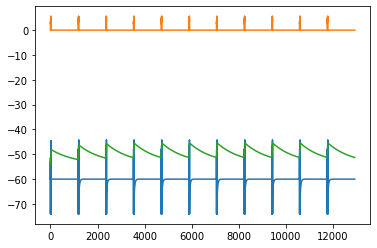

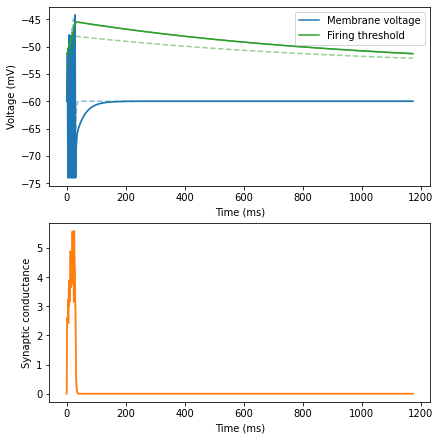

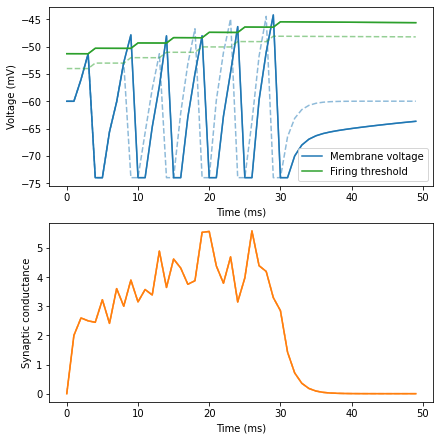

In [29]:
plt.plot(pscattered_recovery_TA_data[-1][-1]['V']/mV)
plt.plot(pscattered_recovery_TA_data[-1][-1]['g'])
plt.plot(pscattered_recovery_TA_data[-1][-1]['th']/mV);
plot_explanatory_figure(params, pscattered_recovery_TA[-1, -1], 10, **pscattered_recovery_TA_data[-1][-1])
plot_explanatory_figure(params, pscattered_recovery_TA[-1, -1], 10, **pscattered_recovery_TA_data[-1][-1], tmax=50*ms)

In [30]:
if simulate:
    pscattered_recovery_STD, pscattered_recovery_STD_data = get_recovery_time_2D(
        {**params, 'th_ampl': 0*mV}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
        isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'))
else:
    pscattered_recovery_STD = ensure_unit(dd.io.load(filename, '/pscattered_recovery_STD'), second)
    pscattered_recovery_STD_data = ensure_unit(dd.io.load(filename, '/pscattered_recovery_STD_data'), {'V':volt, 'spiketimes':second, 'th':volt})

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


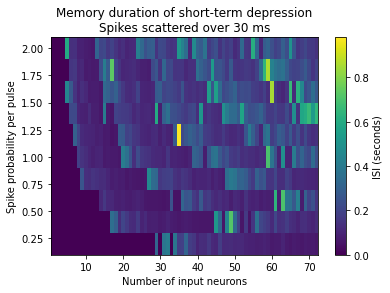

In [31]:
plt.pcolormesh(N_inputs, pspike, pscattered_recovery_STD/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

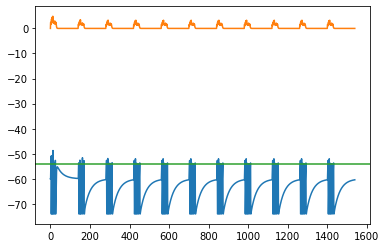

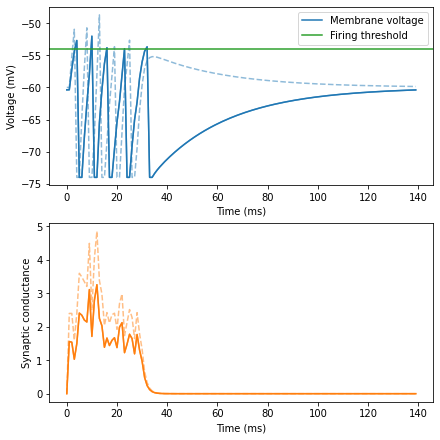

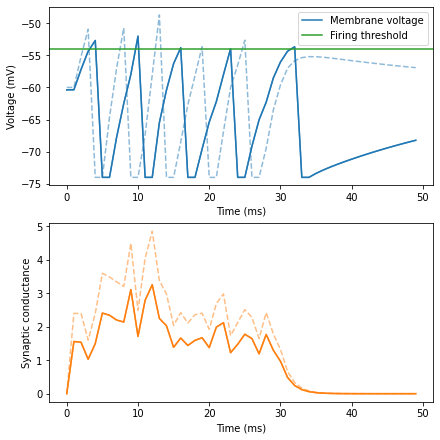

In [32]:
plt.plot(pscattered_recovery_STD_data[-1][-1]['V']/mV)
plt.plot(pscattered_recovery_STD_data[-1][-1]['g'])
plt.axhline(pscattered_recovery_STD_data[-1][-1]['th']/mV, c='C2');
plot_explanatory_figure(params, pscattered_recovery_STD[-1, -1], 10, **pscattered_recovery_STD_data[-1][-1])
plot_explanatory_figure(params, pscattered_recovery_STD[-1, -1], 10, **pscattered_recovery_STD_data[-1][-1], tmax=50*ms)

Great, this gives us a decent idea of how long it takes before the postsynaptic probe returns to firing the same number of spikes.

However, the spike pattern may well matter to downstream recipients, so recovering spike count alone is not enough to claim that the previous pulse is forgotten. Therefore... attempt 5: Exact pattern matching (offsets notwithstanding).

In [33]:
if simulate:
    xpscattered_recovery_TA, xpscattered_recovery_TA_data = get_recovery_time_2D(
        {**params, 'tau_rec': 0*ms}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
        isi=params['th_tau'], min_isi=30*params['dt'], record=('v', 'g_exc', 'th_adapt'), exact=True)
else:
    xpscattered_recovery_TA = ensure_unit(dd.io.load(filename, '/xpscattered_recovery_TA'), second)
    xpscattered_recovery_TA_data = ensure_unit(dd.io.load(filename, '/xpscattered_recovery_TA_data'), {'V':volt, 'spiketimes':second, 'th':volt})

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


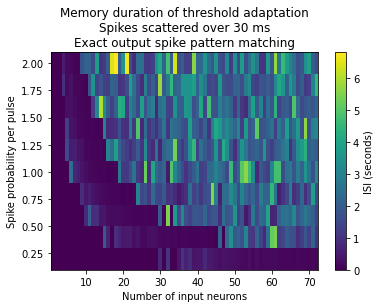

In [34]:
plt.pcolormesh(N_inputs, pspike, xpscattered_recovery_TA/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of threshold adaptation\nSpikes scattered over 30 ms\nExact output spike pattern matching');

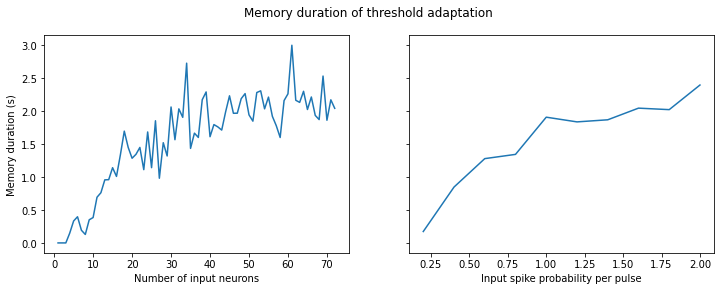

In [35]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_TA, 0)/second)
axs[0].set_xlabel('Number of input neurons')
axs[0].set_ylabel('Memory duration (s)')
axs[1].plot(pspike, np.nanmean(xpscattered_recovery_TA, 1)/second)
axs[1].set_xlabel('Input spike probability per pulse')
fig.suptitle('Memory duration of threshold adaptation');

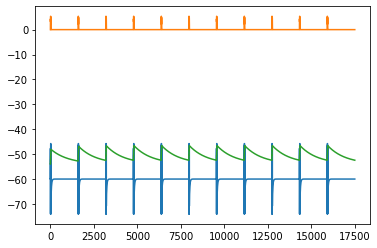

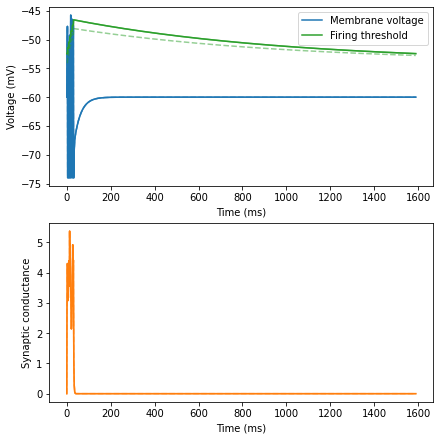

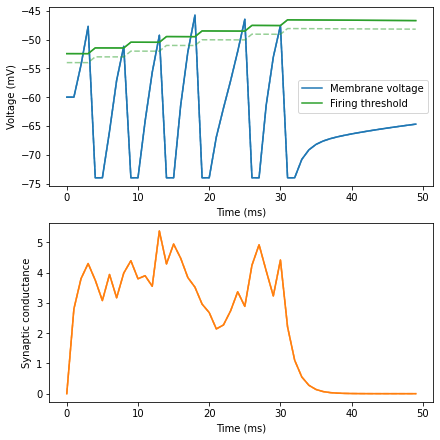

In [36]:
plt.plot(xpscattered_recovery_TA_data[-1][-1]['V']/mV)
plt.plot(xpscattered_recovery_TA_data[-1][-1]['g'])
plt.plot(xpscattered_recovery_TA_data[-1][-1]['th']/mV);
plot_explanatory_figure(params, xpscattered_recovery_TA[-1, -1], 10, **xpscattered_recovery_TA_data[-1][-1])
plot_explanatory_figure(params, xpscattered_recovery_TA[-1, -1], 10, **xpscattered_recovery_TA_data[-1][-1], tmax=50*ms)

In [37]:
if simulate:
    xpscattered_recovery_STD, xpscattered_recovery_STD_data = get_recovery_time_2D(
        {**params, 'th_ampl': 0*mV}, N_inputs, 10, pspike, partial(get_scattered_input, N_ticks=30, dt=params['dt']),
        isi=params['tau_rec'], min_isi=30*params['dt'], record=('v', 'g_exc'), exact=True)
else:
    xpscattered_recovery_STD = ensure_unit(dd.io.load(filename, '/xpscattered_recovery_STD'), second)
    xpscattered_recovery_STD_data = ensure_unit(dd.io.load(filename, '/xpscattered_recovery_STD_data'), {'V':volt, 'spiketimes':second, 'th':volt})

0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0


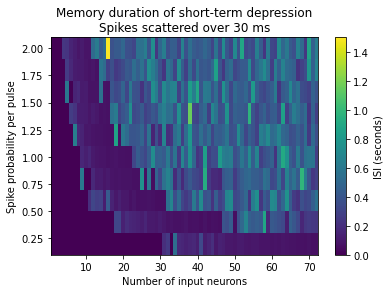

In [38]:
plt.pcolormesh(N_inputs, pspike, xpscattered_recovery_STD/second, vmin=0)
plt.xlabel('Number of input neurons')
plt.ylabel('Spike probability per pulse')
plt.colorbar(label='ISI (seconds)')
plt.title('Memory duration of short-term depression\nSpikes scattered over 30 ms');

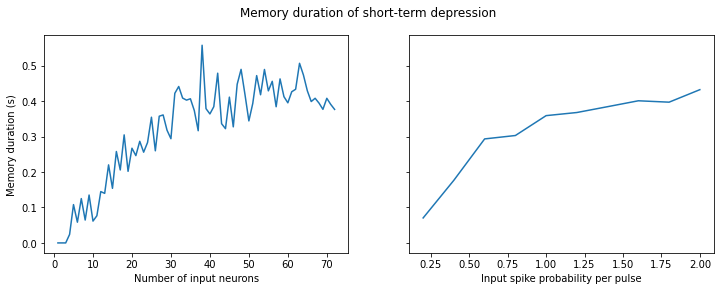

In [39]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
axs[0].plot(N_inputs, np.nanmean(xpscattered_recovery_STD, 0)/second)
axs[0].set_xlabel('Number of input neurons')
axs[0].set_ylabel('Memory duration (s)')
axs[1].plot(pspike, np.nanmean(xpscattered_recovery_STD, 1)/second)
axs[1].set_xlabel('Input spike probability per pulse')
fig.suptitle('Memory duration of short-term depression');

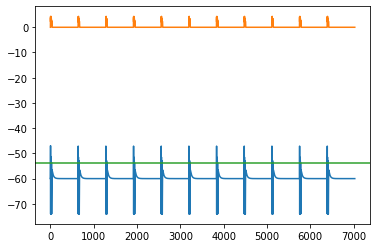

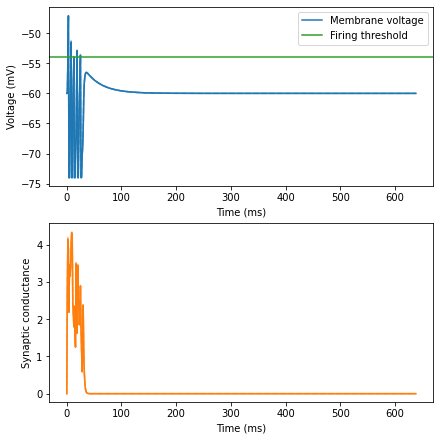

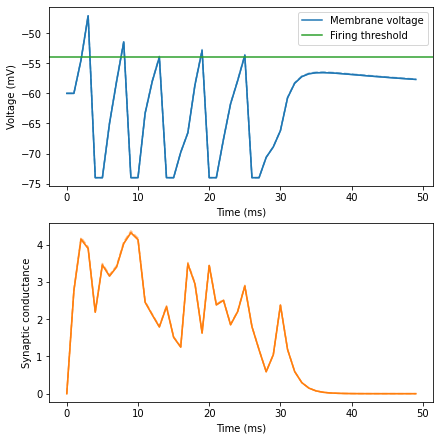

In [40]:
plt.plot(xpscattered_recovery_STD_data[-1][-1]['V']/mV)
plt.plot(xpscattered_recovery_STD_data[-1][-1]['g'])
plt.axhline(xpscattered_recovery_STD_data[-1][-1]['th']/mV, c='C2');
plot_explanatory_figure(params, xpscattered_recovery_STD[-1, -1], 10, **xpscattered_recovery_STD_data[-1][-1])
plot_explanatory_figure(params, xpscattered_recovery_STD[-1, -1], 10, **xpscattered_recovery_STD_data[-1][-1], tmax=50*ms)

I think it's reasonable to describe the durations so identified as a "memory duration" within the given parameters.

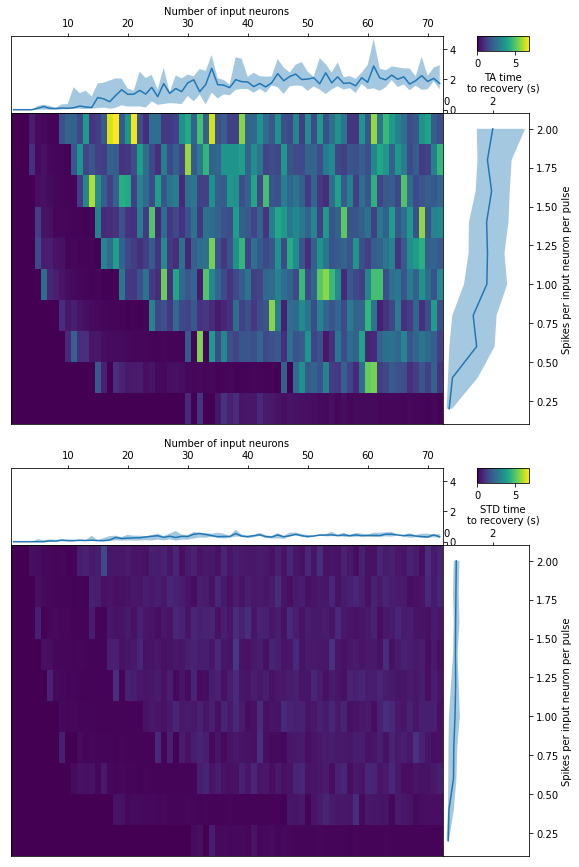

In [47]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(8,12))
axs_top, axs_right = [], []
vmax = max([np.nanmax(recovery) for recovery in (xpscattered_recovery_STD, xpscattered_recovery_TA)])/second
for i, (recovery, title) in enumerate(zip((xpscattered_recovery_STD, xpscattered_recovery_TA), ('STD', 'TA'))):
    gs = GridSpec(2, 2, width_ratios=(5,1), height_ratios=(1,4), wspace=0, hspace=0, left=.05, right=.95, bottom=.5*i, top=.5*(i+1)-.05)
    ax_heat = fig.add_subplot(gs[1,0])
    ax_top = fig.add_subplot(gs[0,0])
    ax_right = fig.add_subplot(gs[1,1])
    ax_label = fig.add_subplot(gs[0,1])
    axs_top.append(ax_top)
    axs_right.append(ax_right)

    m = ax_heat.pcolormesh(N_inputs, pspike, recovery/second, vmin=0, vmax=vmax)

    q = np.nanquantile(recovery, (.25, .5, .75), 0)
    ax_top.plot(N_inputs, q[1]/second)
    ax_top.fill_between(N_inputs, q[0]/second, q[2]/second, alpha=.4)

    q = np.nanquantile(recovery, (.25, .5, .75), 1)
    ax_right.plot(q[1]/second, pspike)
    ax_right.fill_betweenx(pspike, q[0]/second, q[2]/second, alpha=.4)

    ax_top.xaxis.tick_top()
    ax_top.xaxis.set_label_position('top')
    ax_right.yaxis.tick_right()
    ax_right.yaxis.set_label_position('right')
    ax_heat.get_shared_y_axes().join(ax_heat, ax_right)
    ax_heat.get_shared_x_axes().join(ax_heat, ax_top)

    ax_top.yaxis.tick_right()
    ax_heat.set_yticks([])
    ax_heat.set_xticks([])
    ax_right.xaxis.tick_top()

    ax_top.set_xlabel('Number of input neurons')
    ax_right.set_ylabel('Spikes per input neuron per pulse')

    ax_label.axis('off')
    cbax = inset_axes(ax_label, width='60%', height='20%', loc='upper right', borderpad=0)
    plt.colorbar(m, cax=cbax, orientation='horizontal', label=f'{title} time\nto recovery (s)')

ax_top.get_shared_y_axes().join(*axs_top)
ax_right.get_shared_x_axes().join(*axs_right)

In [42]:
if simulate:
    dd.io.save(filename, dict(
        recovery_TA=recovery_TA, recovery_TA_data=recovery_TA_data,
        recovery_STD=recovery_STD, recovery_STD_data=recovery_STD_data,
        scattered_recovery_TA=scattered_recovery_TA, scattered_recovery_TA_data=scattered_recovery_TA_data,
        scattered_recovery_STD=scattered_recovery_STD, scattered_recovery_STD_data=scattered_recovery_STD_data,
        pscattered_recovery_TA=pscattered_recovery_TA, pscattered_recovery_TA_data=pscattered_recovery_TA_data,
        pscattered_recovery_STD=pscattered_recovery_STD, pscattered_recovery_STD_data=pscattered_recovery_STD_data,
        xpscattered_recovery_TA=xpscattered_recovery_TA, xpscattered_recovery_TA_data=xpscattered_recovery_TA_data,
        xpscattered_recovery_STD=xpscattered_recovery_STD, xpscattered_recovery_STD_data=xpscattered_recovery_STD_data
    ))